In [1]:
import xarray as xr
import numpy as np
import intake

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='atmos'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


['2D_daily_avg', '2D_daily_max', '2D_daily_min', '2D_monthly_avg', '2D_monthly_max', '2D_monthly_min', '3D_daily_avg', '3D_monthly_avg', '3D_6hourly', '2D_6hourly_accumulated', '2D_6hourly_instant']


In [2]:
ds = cat_data['2D_daily_avg'](chunks="auto").to_dask()
ds

<xarray.Dataset>
Dimensions:    (time: 23741, value: 6599680)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    erate      (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10u       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10v       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2d        (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2sh       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrf    (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtsfr      (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    tprate     (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
Attributes: (12/36)
    edition:               2
    centre:                ecmf
    centreDescription:     European Centre for Medium-Range Weather Forecasts
    subCentre:             0
    history:               🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan...
    Conventions:           CF-1.7 CMIP-6.2
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [3]:
lon = ds.lon.values
lat = ds.lat.values
areas_file = xr.open_dataset('/work/ab0246/a270092/input/oasis/cy43r3/TCO1279-DART/areas.nc')
areas = areas_file['A128.srf']
areas = areas[0,:].rename({'x_A128': 'value'})

In [4]:
data_sample = ds['mean2t'][0,:]

### Spatial mean the wrong way

In [5]:
data_sample.mean(dim="value").values

array(286.24295138)

## Right way (weighted mean)

In [6]:
((data_sample*areas).sum(dim='value')/areas.sum(dim='value')).values

array(284.64260236)

## Create time series

In [7]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=20, threads_per_worker=1, memory_limit='10GB')
client

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36141,Workers: 20
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:44689,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/37687/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:42601,


In [8]:
ds = cat_data['2D_daily_avg'](chunks="auto").to_dask()

In [9]:
time_period = ds['mean2t'].sel(time=slice('1950', '1955'))

In [10]:
time_period

<xarray.DataArray 'mean2t' (time: 2191, value: 6599680)>
dask.array<getitem, shape=(2191, 6599680), dtype=float64, chunksize=(2, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1955-12-31T12:00:00
Dimensions without coordinates: value
Attributes: (12/24)
    paramId:                          228004
    dataType:                         fc
    numberOfPoints:                   6599680
    typeOfLevel:                      heightAboveGround
    stepUnits:                        1
    stepType:                         avg
    ...                               ...
    indicatorOfUnitForTimeRange:      1
    productDefinitionTemplateNumber:  8
    N:                                1280
    timeRangeIndicator:               0
    stepRange:                        0-24
    pl:                               [20, 24, 28, 32, 36, 40, 44, 48, 52, 56...

In [11]:
time_period*areas

<xarray.DataArray (time: 2191, value: 6599680)>
dask.array<mul, shape=(2191, 6599680), dtype=float64, chunksize=(2, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat       (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon       (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1950-01-01T12:00:00 ... 1955-12-31T12:00:00
    A128.lon  (value) float64 ...
    A128.lat  (value) float64 ...
Dimensions without coordinates: value

In [12]:
temp_mean = ((time_period*areas).sum(dim='value')/areas.sum(dim='value'))

In [13]:
temp_mean

<xarray.DataArray (time: 2191)>
dask.array<truediv, shape=(2191,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1955-12-31T12:00:00

In [14]:
%%time
temp_mean=temp_mean.compute()

CPU times: user 15.4 s, sys: 1.36 s, total: 16.8 s
Wall time: 41.4 s


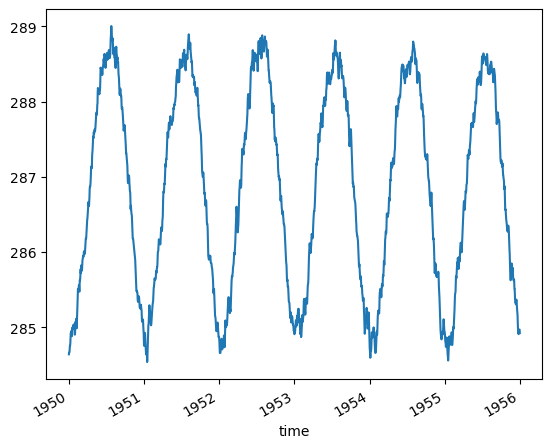

In [15]:
temp_mean.plot()

## Select region by lon/lat box

In [16]:
left = 120
right = 140
bottom = 30
top = 45

In [17]:
region = (lon < right) & (lon>left) & (lat > bottom) & (lat < top)

In [18]:
((data_sample[region]*areas[region]).sum(dim='value')/areas[region].sum(dim='value')).values

array(270.90016925)

In [21]:
temp_mean_region = ((time_period[:, region]*areas[region]).sum(dim='value')/areas[region].sum(dim='value'))

In [22]:
temp_mean_region

<xarray.DataArray (time: 2191)>
dask.array<truediv, shape=(2191,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1955-12-31T12:00:00

In [23]:
%%time
temp_mean_region=temp_mean_region.compute()

CPU times: user 12.8 s, sys: 980 ms, total: 13.8 s
Wall time: 30.1 s


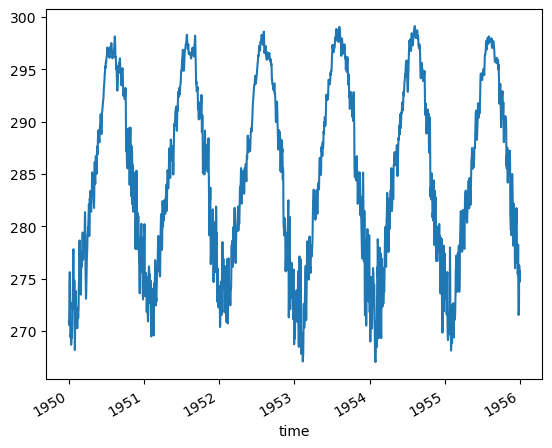

In [24]:
temp_mean_region.plot()

## Compute monthly means from daily data

In [8]:
ds['mean2t']

<xarray.DataArray 'mean2t' (time: 23741, value: 6599680)>
dask.array<open_dataset-fbb2a3757a99cace4bb35f581ceded94mean2t, shape=(23741, 6599680), dtype=float64, chunksize=(2, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Dimensions without coordinates: value
Attributes: (12/24)
    paramId:                          228004
    dataType:                         fc
    numberOfPoints:                   6599680
    typeOfLevel:                      heightAboveGround
    stepUnits:                        1
    stepType:                         avg
    ...                               ...
    indicatorOfUnitForTimeRange:      1
    productDefinitionTemplateNumber:  8
    N:                                1280
    timeRangeIndicator:               0
    stepRange:                        0-24
    pl:                               [20, 24, 28, 32, 36, 40, 44, 48, 52, 56...

In [10]:
mm = ds['mean2t'].sel(time=slice("1950", "1959")).resample(time="1MS").mean(dim='time')

In [11]:
mm

<xarray.DataArray 'mean2t' (time: 120, value: 6599680)>
dask.array<stack, shape=(120, 6599680), dtype=float64, chunksize=(1, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1959-12-01
Dimensions without coordinates: value
Attributes: (12/24)
    paramId:                          228004
    dataType:                         fc
    numberOfPoints:                   6599680
    typeOfLevel:                      heightAboveGround
    stepUnits:                        1
    stepType:                         avg
    ...                               ...
    indicatorOfUnitForTimeRange:      1
    productDefinitionTemplateNumber:  8
    N:                                1280
    timeRangeIndicator:               0
    stepRange:                        0-24
    pl:                               [20, 24, 28, 32, 36, 40, 44, 48, 52, 56...

In [12]:
%%time
mm = mm.compute()

CPU times: user 34.8 s, sys: 14.2 s, total: 49 s
Wall time: 1min 52s


In [18]:
mm

<xarray.DataArray 'mean2t' (time: 120, value: 6599680)>
array([[243.66924409, 243.67300612, 243.6717677 , ..., 255.68968496,
        255.68287314, 255.67309816],
       [240.25419617, 240.25882557, 240.26357923, ..., 248.02001081,
        248.01456724, 248.01648494],
       [242.64770557, 242.67493857, 242.69517173, ..., 228.86605343,
        228.99827083, 229.09518482],
       ...,
       [254.51557972, 254.52164779, 254.54019214, ..., 236.64825341,
        236.69488378, 236.72847083],
       [245.96132558, 245.96102295, 245.96139018, ..., 257.82139791,
        257.82045848, 257.80325267],
       [250.50622263, 250.49494639, 250.48369328, ..., 262.83065304,
        262.82764459, 262.81295481]])
Coordinates:
    lat      (value) float64 89.95 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (value) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1959-12-01
Dimensions without coordinates: value
Attributes: (12/24)
    paramId:                          228004
    dataType:                         fc
    numberOfPoints:                   6599680
    typeOfLevel:                      heightAboveGround
    stepUnits:                        1
    stepType:                         avg
    ...                               ...
    indicatorOfUnitForTimeRange:      1
    productDefinitionTemplateNumber:  8
    N:                                1280
    timeRangeIndicator:               0
    stepRange:                        0-24
    pl:                               [20, 24, 28, 32, 36, 40, 44, 48, 52, 56...

## Save result to netCDF

In [19]:
mm.to_netcdf('/work/ab0995/a270088/ICCPhackathon/monthly_means_1950_1959.nc')